# Methods for Multiscale Comparative Connectomics

This demo shows you how to use methods in `graspologic` to analyze patterns
in brain connectivity in connectomics datasets. We specifically demonstrate
methods for identifying differences in edges and vertices across subjects. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

## Load the Duke mouse brain dataset

Dataset of 32 mouse connectomes derived from whole-brain diffusion
magnetic resonance imaging of four distinct mouse genotypes:
BTBR T+ Itpr3tf/J (BTBR), C57BL/6J(B6), CAST/EiJ (CAST), and DBA/2J (DBA2).
For each strain, connectomes were generated from eight age-matched mice
(N = 8 per strain), with a sex distribution of four males and four females.
Each connectome was parcellated using asymmetric Waxholm Space, yielding a
vertex set with a total of 332 regions of interest (ROIs) symmetrically
distributed across the left and right hemispheres. Within a given
hemisphere, there are seven superstructures consisting up multiple ROIs,
resulting in a total of 14 distinct communities in each connectome.

In [2]:
from graspologic.datasets import load_mice

In [3]:
# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Get sample parameters
n_subjects = mice.meta["n_subjects"]
n_vertices = mice.meta["n_vertices"]

In [4]:
# Split the set of graphs by genotype
btbr = graphs[mice.labels == "BTBR"]
b6 = graphs[mice.labels == "B6"]
cast = graphs[mice.labels == "CAST"]
dba2 = graphs[mice.labels == "DBA2"]

connectomes = [btbr, b6, cast, dba2]

## Identifying Signal Edges

The simplest approach for comparing connectomes is to treat them as a _bag of edges_ without considering interactions between the edges.
Serially performing univariate statistical analyses at each edge enables the discovery of _signal edges_ whose neurological connectivity differs across categorical or dimensional phenotypes.
Here, we demonstrate the possibility of using Distance Correlation (`Dcorr`), a nonparametric universally consistent test, to detect changes in edges.

In this model, we assume that each edge in the connectome is independently and
identically sampled from some distribution $F_i$, where $i$ represents the group
to which the given connectome belongs. In this setting the groups are the mouse
genotypes. `Dcorr` allows us to test the following hypothesis:

\begin{align*}
H_0:\ &F_1 = F_2 = \ldots F_k \\
H_A:\ &\exists \ j \neq j' \text{ s.t. } F_j \neq F_{j'}
\end{align*}

In [5]:
from hyppo.ksample import KSample

Since the connectomes in this dataset are undirected, we only need to do edge
comparisons on the upper triangle of the adjacency matrices.

In [6]:
# Make iterator for traversing the upper triangle of the connectome
indices = zip(*np.triu_indices(n_vertices, 1))

In [7]:
edge_pvals = []

for roi_i, roi_j in indices:
    
    # Get the (i,j)-th edge for each connectome
    samples = [genotype[:, roi_i, roi_j] for genotype in connectomes]
    
    # Calculate the p-value for the (i,j)-th edge
    try:
        statistic, pvalue = KSample("Dcorr").test(*samples, reps=10000, workers=-1)
    except ValueError:
        # A ValueError is thrown when any of the samples have equal edge 
        # weights (i.e. one of the inputs has 0 variance)
        statistic = np.nan
        pvalue = 1

    edge_pvals.append([roi_i, roi_j, statistic, pvalue])

Connectomes are a high-dimensional dataype.
Thus, statistical tests on components of the connectome (e.g. edge and vertices)
results in multiple comparisons.
We recommend correcting for multiple comparisons using the Holm-Bonferroni (HB)
corection.

The algorithm is described below:
1. Sort the p-values from lowest-to-highest $P_1, P_2, \dots, P_n$, where $n$ is the number of tests
2. Correct the p-value as $P_1(n), P_2(n-1), \dots, P_n(1)$
3. If any corrected p-value is $>1$, replace with $1$
4. If the corrected p-value is less than a significance level $\alpha$, reject

In [8]:
# Convert the nested list to a dataframe
edge_pvals = pd.DataFrame(edge_pvals, columns=["ROI_1", "ROI_2", "stat", "pval"])

# Correct p-values using the Holm-Bonferroni correction
edge_pvals.sort_values(by="pval", inplace=True, ignore_index=True)
pval_rank = edge_pvals["pval"].rank(ascending=False, method="max")
edge_pvals["holm_pval"] = edge_pvals["pval"].multiply(pval_rank)
edge_pvals["holm_pval"] = edge_pvals["holm_pval"].apply(
    lambda pval: 1 if pval > 1 else pval
)

# Test for significance using alpha=0.05
alpha = 0.05
edge_pvals["significant"] = (edge_pvals["holm_pval"] < alpha)

# Get the top 10 strongest signal edges
edge_pvals_top = edge_pvals.head(10)

# Replace ROI indices with actual names
def lookup_roi_name(index):
    hemisphere = "R" if index // 166 else "L"
    index = index % 166
    roi_name = mice.atlas.query(f"ROI == {index+1}")["Structure"].item()
    return f"{roi_name} ({hemisphere})"

edge_pvals_top["ROI_1"] = edge_pvals_top["ROI_1"].apply(lookup_roi_name)
edge_pvals_top["ROI_2"] = edge_pvals_top["ROI_2"].apply(lookup_roi_name)

edge_pvals_top.head()

,ROI_1,ROI_2,stat,pval,holm_pval,significant
0,Corpus_Callosum (L),Striatum (R),0.717036,9.911903e-07,0.054462,False
1,Corpus_Callosum (L),Internal_Capsule (R),0.699473,1.327371e-06,0.072932,False
2,Corpus_Callosum (L),Reticular_Nucleus_of_Thalamus (R),0.698197,1.355858e-06,0.074496,False
3,Corpus_Callosum (L),Zona_Incerta (R),0.685735,1.668308e-06,0.091662,False
4,Septum (R),Corpus_Callosum (R),0.670809,2.139082e-06,0.117525,False


Note that none of the edges achieve significance at $\alpha=0.05$ following 
Holm-Bonferroni correction.
We might expect this, given that we are correcting for $N=54,946$ tests.
Instead of the magnitude, the **ranking of the p-values** can be used to determine signal edges.

## Identifying Signal Vertices

A sample of connectomes can be jointly embedded in a low-dimensional Euclidean space using the omnibus embedding (`omni`).
A host of machine learning tasks can be accomplished with this joint embedded representation of the connectome, such as clustering or classification of vertices.
Here, we use the embedding to formulate a statistical test that can be used to identify vertices that are strongly associated with given phenotypes.
According to a Central Limit Theorem for `omni`, these latent positions are universally consistent and asymptotically normal.

In [9]:
from graspologic.embed import OmnibusEmbed
from graspologic.plot import pairplot

In [10]:
# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
print(omni_embedding.shape)

(32, 332, 5)


For each of the 32 mice, `omni` embeds each vertex in the connectome to a
latent position vector $x_i \in \mathbb{R}^5$.
We test for differences in the distribution of vertex latent positions using 
the `MGC` independence test implemented in `hyppo`.
This test essentially acts as a nonparametric MANOVA test.

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module="hyppo")
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    vertex_pvals = []

    for vertex_i in range(n_vertices):
    
    # Get the embedding of the i-th vertex for 
        samples = [
            omni_embedding[mice.labels==genotype, vertex_i, :] 
            for genotype in np.unique(mice.labels)
        ]
    
    # Calculate the p-value for the i-th vertex
        statistic, pvalue, _ = KSample("MGC").test(
            *samples, reps=250, workers=-1
        )
        vertex_pvals.append([vertex_i, statistic, pvalue])

**Important:** When running on data, make sure `reps` $\geq \frac{|V|}{\alpha}$ where $|V|$ is the cardinality of the vertex set and $\alpha$ is the significance level for your test.
Again, this has to do with p-value correction:
because `MGC` is a permutation test, you need many replications to ensure accurate computation of the p-value.
Because this notebook is primarily for demonstration purposes, we use a small value of `reps=250`. For this dataset, a more appropriate number of permutations would be around $10^6$.

In [12]:
# Convert the nested list to a dataframe
vertex_pvals = pd.DataFrame(vertex_pvals, columns=["ROI", "stat", "pval"])

# Correct p-values using the Holm-Bonferroni correction
vertex_pvals.sort_values(by="pval", inplace=True, ignore_index=True)
pval_rank = vertex_pvals["pval"].rank(ascending=False, method="max")
vertex_pvals["holm_pval"] = vertex_pvals["pval"].multiply(pval_rank)
vertex_pvals["holm_pval"] = vertex_pvals["holm_pval"].apply(
    lambda pval: 1 if pval > 1 else pval
)

# Test for significance using alpha=0.05
alpha = 0.05
vertex_pvals["significant"] = (vertex_pvals["holm_pval"] < alpha)

# Get the top 10 strongest signal edges
vertex_pvals_top = vertex_pvals.head(10)

# Replace ROI indices with actual names
vertex_pvals_top["ROI"] = vertex_pvals_top["ROI"].apply(lookup_roi_name)

vertex_pvals_top.head()

,ROI,stat,pval,holm_pval,significant
0,Cingulate_Cortex_Area_24a (L),0.754901,0.004,1.0,False
1,Amygdalopiriform_Transition_Area (R),0.526762,0.004,1.0,False
2,Piriform_Cortex (R),0.603432,0.004,1.0,False
3,Presubiculum (R),0.292116,0.004,1.0,False
4,Perirhinal_Cortex (R),0.806250,0.004,1.0,False


We can use pairplots to visualize the embeddings of specific vertices.
Below are pairsplots of the corpus callosum from the left and right hemispheres.

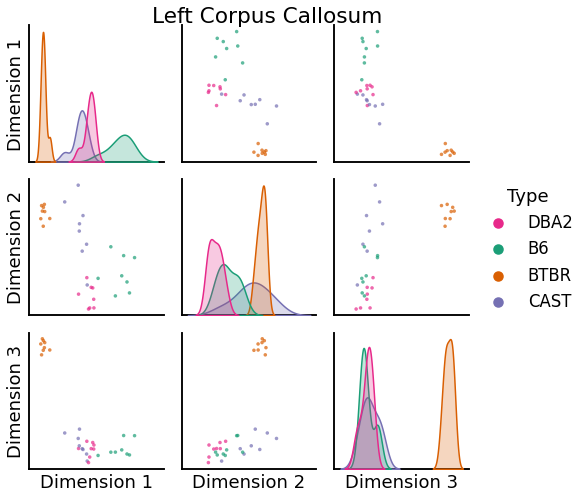

In [13]:
left = pairplot(
    omni_embedding[:, 121 - 1, :3], 
    mice.labels, 
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    title="Left Corpus Callosum"
)

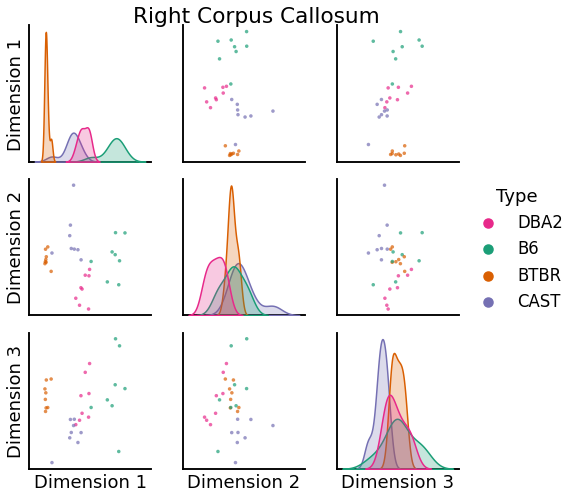

In [14]:
right = pairplot(
    omni_embedding[:, 121 + 166 - 1, :3], 
    mice.labels, 
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    title="Right Corpus Callosum",
)

## Whole-brain Comparisons

We can use the results of the omnibus embedding to perform whole-brain comparisons
across subjects from different phenotypes.

In [15]:
from graspologic.embed import ClassicalMDS
from graspologic.plot import heatmap

Two-dimensional representations of each connectome were obtained by using 
Classical Multidimensional Scaling (`cmds`) to reduce the dimensionality 
of the embeddings obtained by `omni`.

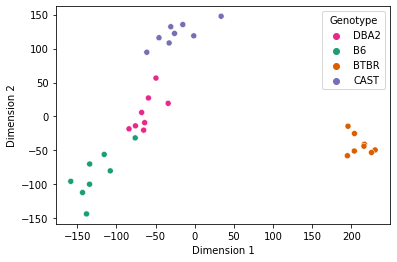

In [16]:
# Further reduce embedding dimensionality using cMDS
cmds = ClassicalMDS(2)
cmds_embedding = cmds.fit_transform(omni_embedding)
cmds_embedding = pd.DataFrame(cmds_embedding, columns=["Dimension 1", "Dimension 2"])
cmds_embedding["Genotype"] = mice.labels

# Embedding with BTBR
sns.scatterplot(
    x="Dimension 1",
    y="Dimension 2",
    hue="Genotype",
    data=cmds_embedding,
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
)
plt.show()

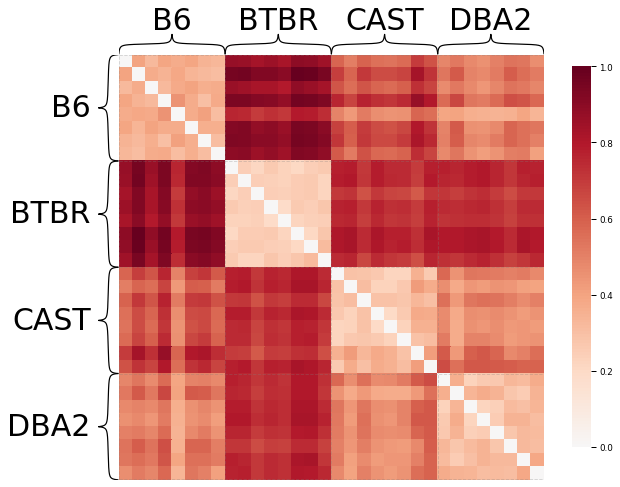

In [17]:
# Find the dissimilarity between subjects' connectomes using the cMDS embedding
dis = cmds.dissimilarity_matrix_
scaled_dissimilarity = dis / np.max(dis)

heatmap(scaled_dissimilarity,
        context="paper",
        inner_hier_labels=mice.labels,)
plt.show()

Notice that mice from the same genotype are most similar to each other, as expected.